# Model Architecture

We have 4000 total labeled sample images in total to work with. That means 2000 fire images and 2000 non-fire images. Among them I have used 3000 images for training and 1000 for testing equally splitting among both the labels. Although this dataset is of decent size, it is not enough to train the model from scratch using keras model. And as we see later it is not necessary as well. Instead we can use some of the pretrained model. 

I use VGG16 pretrained model. VGG-16 is a trained Convolutional Neural Network (CNN), from Visual Geometry Group (VGG), Department of Engineering Science, University of Oxford. The number 16 means the number of layers with trainable weights. The reference paper is here: 

https://arxiv.org/abs/1409.1556



A review article is here: 

https://neurohive.io/en/popular-networks/vgg16/


Pretrained model are trained in different data, not necessarily similar to the data we are training in this model. But we can still use it because of the follwing reason: The CNN has series of layers. Each layer learns a set of features from the image data. The lower layers learn fundamental patterns like edeges, lines, curves etc. The higher layers on the other hand are specific to the images on the model. Hence, the featured learned by the lower level can be general to the large class of images, even the images which model did not see during its training. Because of this reason we only use the base of the pre-trained model removing the top. We do this here in two steps. 

First, we retain all the base and remove only the dense top layer and train the model. Which gives us validation accuracy close to 90%. And in second step, we unlock the top convolutional model on the base and further train the model. Since we already have a decent accuracy we can imagine that the model is already close to the optimum model. So we only need to fine tune. For this reason we drop the learning rate to 10% of the previous case and train for larger number of iterations. Doing so we achieve a validation accuracy close to 97%. Which is pretty decent result. 

#### Importing packages 

In [1]:
import os                                     # operating system 
import numpy as np                            # linear algebra 
from PIL import Image                         # Python image library 
import matplotlib.pyplot as plt               # making plots
%matplotlib inline 
from IPython.display import display           # displaying ?

import warnings                               # ignoring unnecessary python warnings 
warnings.filterwarnings('ignore')

from keras.applications import VGG16                         # pretrained CNN                        
from keras.callbacks import ModelCheckpoint                  # furter train the saved model 
from keras import models, layers, optimizers                 # building DNN is keras 
from tensorflow.keras.models import load_model               # load saved model 
from tensorflow.keras.preprocessing.image import ImageDataGenerator     # preparing image data for training 

#### Setting up model 

We set the model with VGG16 base and custom top. 

- Loss: Since this is classification problem and there are two classes, we use the binary cross-entropy as the loss function. 

- Optimizer: We use RMSprop optimizer with customized learning rate. 

- Metrics: In addition to the loss we want to observe the accuracy. We optimize our model based on this metric.

In [2]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                 include_top=False,
                 input_shape=(150, 150, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False

model.compile(loss='binary_crossentropy', 
             optimizer=optimizers.RMSprop(learning_rate=1e-4), 
             metrics=['accuracy'])

print("Model successfully built!")


Model successfully built!


Here is the summary of the model. 

In [3]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Preparing the data 

#### Calling test and train image directories 

These directories were prepared in the other notebook. 

In [4]:
base_dir = 'D:/Fire_detection_Model/Images'

train_dir = os.path.join(base_dir, 'train')
train_dir_fire = os.path.join(train_dir, 'fire')
train_dir_nofire = os.path.join(train_dir, 'nofire')

test_dir = os.path.join(base_dir, 'test')
test_dir_fire = os.path.join(test_dir, 'fire')
test_dir_nofire = os.path.join(test_dir, 'nofire')

#### Data generator & data augmentation 

For the large dataset it is not convenient to load all the data into memory. So we use image data generator to load the data from hard disc to memory in small batch. We do the same of the training and test set. 

Further, when initiating the image data generator we can do the data augmentation. This is the step to create more data from existing data by transforming the image. This artificially provides more data to train. Here we use rotation, translation, shear, zooming and horizontal flip for data augmentation. Other transformations like verticle flip is not suitable. We only do the data augmentation in the training set and not on the validation and test set. 

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                   target_size=(150, 150), 
                                                   batch_size=32,
                                                   class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir, 
                                                   target_size=(150, 150), 
                                                   batch_size=32,
                                                   class_mode='binary')

Found 1258 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


# Training the model 

We pass the training data from the train_generator. We train for 30 epochs. We pass the validation data from the validation_generator.  We get validation accuracy above to 90% from this. 

In [6]:
history = model.fit(train_generator, epochs=30, 
                    validation_data=test_generator)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.6197 - loss: 0.6975 - val_accuracy: 0.6640 - val_loss: 0.6249
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.7766 - loss: 0.4748 - val_accuracy: 0.8142 - val_loss: 0.4148
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.7942 - loss: 0.4346 - val_accuracy: 0.7470 - val_loss: 0.5385
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.8098 - loss: 0.4066 - val_accuracy: 0.8617 - val_loss: 0.3492
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8436 - loss: 0.3579 - val_accuracy: 0.7628 - val_loss: 0.5471
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8276 - loss: 0.3905 - val_accuracy: 0.8142 - val_loss: 0.4335
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.8361 - loss: 0.3856 - val_accuracy: 0.8814 - val_loss: 0.3162
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8460 - loss: 0.3440 - val_accuracy: 0.8538 - val_loss:

Saving the model for the future use. 

In [7]:
model.save('VGG16_lr-4.h5')

#### Visualization of the learning 

Training gives four sets of values in each eopch

- Training accuracy 
- Validation accuracy 
- Training loss 
- Validation loss 

In [8]:
# Dictionary to extract the numbers 
hist_dict = history.history

# Training and validation accuracy 
training_acc = hist_dict['accuracy']
validation_acc = hist_dict['val_accuracy']

# Training and validation loss 
training_loss = hist_dict['loss']
validation_loss = hist_dict['val_loss']

# Number of epochs 
epoches = range(1, 1 + len(training_acc))

#### Function to make plot 

In [9]:
def plot_func(entity):
    
    '''
    This function produces plot to compare the performance 
    between train set and validation set. 
    entity can be loss of accuracy. 
    '''
    
    plt.figure(figsize=(8, 5))
    plt.plot(epoches, eval('training_' + entity), 'r')
    plt.plot(epoches, eval('validation_' + entity), 'b')
    plt.legend(['Training ' + entity, 'Validation ' + entity])
    plt.xlabel('Epoches')
    plt.ylabel(entity)
    plt.show()

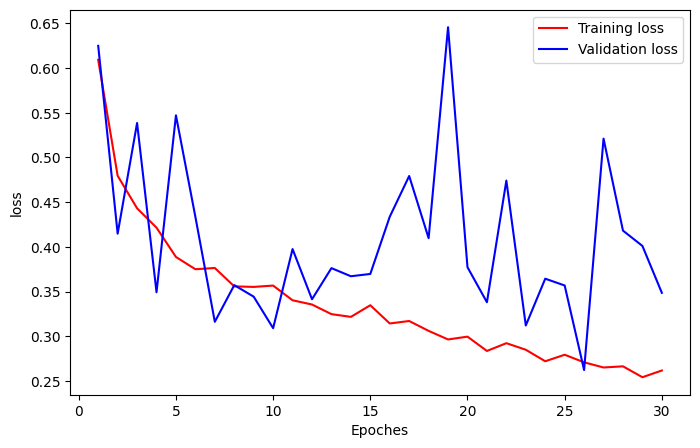

In [10]:
plot_func('loss')

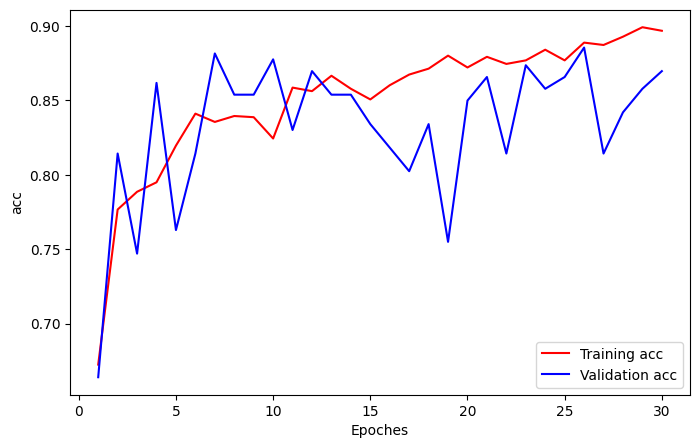

In [11]:
plot_func('acc')

# Fine tuning the model

#### Unlocking the top convolutional block 

We trained previosuly with only top layer removed from VGG16. Here we unlock top base layer from VGG16 and fine tune the model. Doing so we reduce the learning rate from $10^{-4}$ to $10^{-5}$. We train for the 50 epoches. The model surpass the validation accuracy of 97% shortly after 30 epochs. It is not unlikely to improve the model after 50 epochs. But I am happy with this for now. The future plan is to check with other pre-trained model rather. 

In [12]:
from tensorflow.keras import optimizers
conv_base.trainable = True
for layer in conv_base.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
        layer.trainable = True
    else:
        layer.trainable = False
model.compile(loss='binary_crossentropy', 
             optimizer=optimizers.RMSprop(learning_rate=1e-5),  
             metrics=['acc'])

#### Fitting the model 

In [13]:
history = model.fit(train_generator, epochs=50, 
                             validation_data=test_generator)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - acc: 0.9064 - loss: 0.2462 - val_acc: 0.8577 - val_loss: 0.3761
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - acc: 0.9074 - loss: 0.2379 - val_acc: 0.8696 - val_loss: 0.3801
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - acc: 0.9338 - loss: 0.2000 - val_acc: 0.8775 - val_loss: 0.3569
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - acc: 0.9228 - loss: 0.1892 - val_acc: 0.8775 - val_loss: 0.3354
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - acc: 0.9114 - loss: 0.1965 - val_acc: 0.8617 - val_loss: 0.3936
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - acc: 0.9346 - loss: 0.1726 - val_acc: 0.8972 - val_loss: 0.3236
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - acc: 0.9386 - loss: 0.1623 - val_acc: 0.8340 - val_loss: 0.5191
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - acc: 0.9240 - loss: 0.1826 - val_acc: 0.8656 - val_loss: 0.4079
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - acc: 0.9456 - loss: 

In [14]:
model.save('VGG16_fine_tuned.h5')

#### Visualization of fine tuning process

In [15]:
hist_dict = history.history

training_accuracy = hist_dict['acc']
validation_accuracy = hist_dict['val_acc']

training_loss = hist_dict['loss']
validation_loss = hist_dict['val_loss']

epoches = range(1, 1 + len(training_acc))

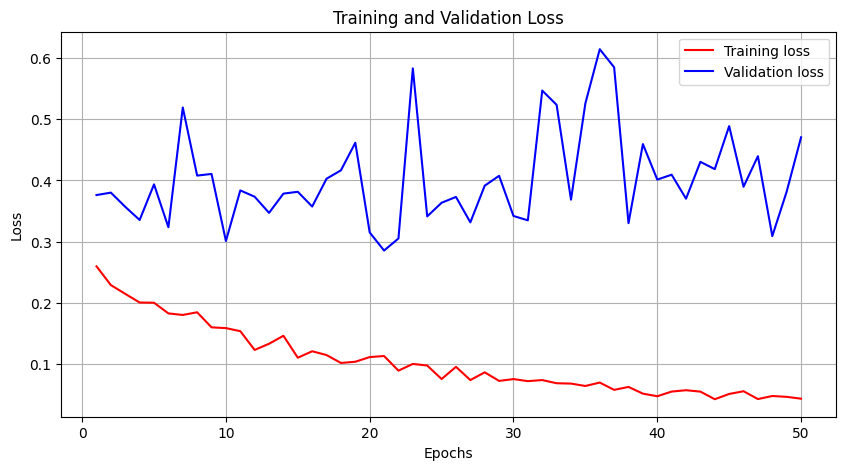

In [16]:
import matplotlib.pyplot as plt

# استخراج بيانات Loss من التاريخ
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# إنشاء الرسم البياني
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'r', label='Training loss')  # blue dots with line
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # red dots with line

# إضافة العناوين والتنسيق
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# إظهار الرسم
plt.show()

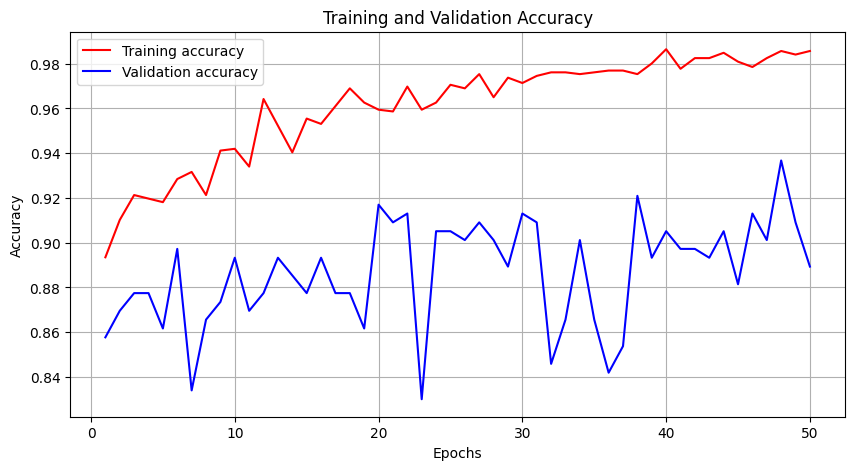

In [17]:
import matplotlib.pyplot as plt

# استخراج بيانات Accuracy من التاريخ
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)

# إنشاء الرسم البياني
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'r', label='Training accuracy')  # خط التدريب (أحمر)
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')  # خط التحقق (أزرق)

# تنسيق الرسم
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# إظهار الرسم
plt.show()

# Error Analysis

In this section we analyze the error of the model, i.e. mis-classified images. We first see few examples of the correctly classified images. Then we visualize the confusion matrix. And finally, we see separately fire images classified as non-fire and non-fire images classified as fire.  

In [18]:
# Loading the saved model 
model = load_model('VGG16_fine_tuned.h5')

#### Getting the labels and predictions 

In [19]:
# taking first batch from the generator 
img, label = test_generator[0] 

# Predicting the images from the first batch 
pred = np.round(model.predict(img)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [20]:
len(img)

32

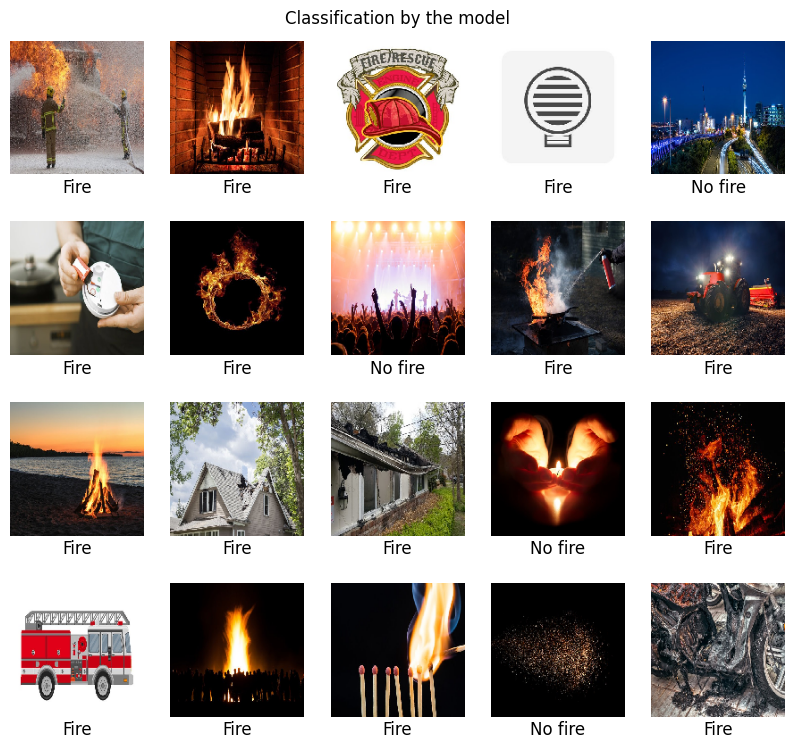

In [21]:
# Numeric to semantic labels 
label_dict = {1.0: 'No fire', 0.0: 'Fire'}

# Generating collage of plots 
fig = plt.figure(figsize=(10, 9))
plt.title('Classification by the model')
plt.axis('off')

for i, img_i in enumerate(img[:20]):
    ax = fig.add_subplot(4, 5, i+1)
    plt.axis('off')
    plt.title(label_dict[pred[i]], y=-0.2)
    ax.imshow(img_i)

#### Extracting misclassified images

In [22]:
import numpy as np

# Lists for missed fire images and missed non-fire images
msd_fire = []
msd_nofire = []

# Iterating through all the batches
for j in range(31):  # Assuming there are 31 batches in the test set
    # Get the batch of images and labels from the test_generator
    img, label = next(test_generator)  # Use next() to get the batch of data
    
    # Predict the labels for the batch of images
    pred = np.round(model.predict(img)).flatten()
    
    # Compare the predictions with the true labels
    bool_list = label == pred
    
    # bool_list is False when there is misclassification
    for i, e in enumerate(bool_list):
        if not e:  # Misclassification
            # Separating labels (fire and non-fire)
            if label[i] == 0:
                msd_fire.append(img[i])  # Misclassified fire image
            else:
                msd_nofire.append(img[i])  # Misclassified non-fire image

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

#### Confusion matrix

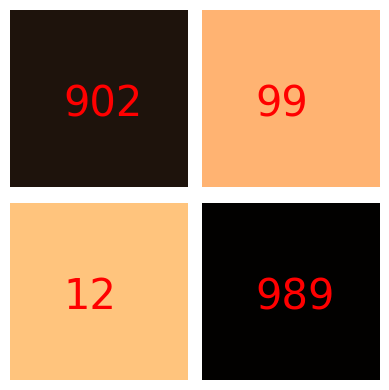

In [23]:
# total number of sample in train set in each class 
n_class = 1001

# number of misclassified fire and non-fire images 
nm_fire, nm_nofire = len(msd_fire), len(msd_nofire)

# confusion matrix (flattened)
conf_mat = [n_class-nm_fire, nm_fire, nm_nofire, n_class-nm_nofire]

# visualization of confusion matrix 
fig = plt.figure(figsize=(4, 4))
for i, j in enumerate(conf_mat):
    ax = fig.add_subplot(2, 2, i+1)
    ax.imshow([[j]], vmin=0, vmax=1000, cmap='copper_r')
    ax.text(-0.2, 0.1, j, c='r', fontsize=30)
    ax.axis('off')

# bringing blocks tighter 
fig.tight_layout()
fig.show()

#### Showing mis-classified fire images 

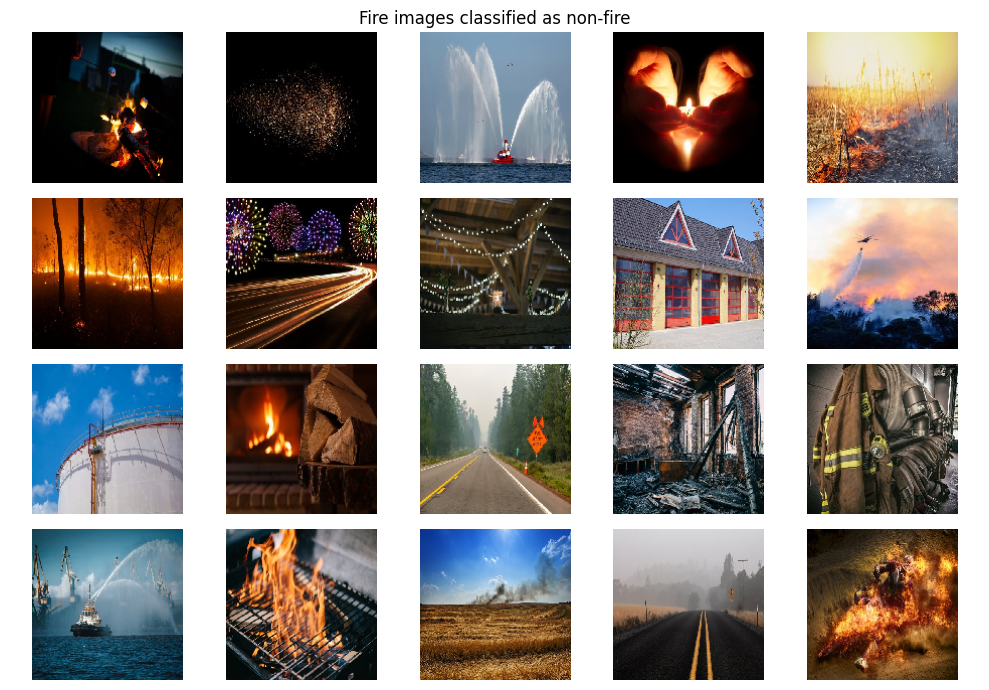

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
plt.title('Fire images classified as non-fire')
plt.axis('off')

# Limit to a maximum of 20 images for plotting
max_images = 20
msd_fire_limited = msd_fire[:max_images]  # Limiting to the first 20 images

# Loop through misclassified fire images and plot them
for i, img_i in enumerate(msd_fire_limited):
    ax = fig.add_subplot(4, 5, i + 1)
    
    # Check if image is in the correct format and shape
    if img_i.shape[-1] == 3:  # Ensure image has 3 color channels (RGB)
        ax.imshow(img_i)
    else:
        # Convert grayscale images to RGB before displaying
        ax.imshow(img_i, cmap='gray')
    
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


Some of the misclassified figure have fire but that is too small. So even human observer is easy to confuse with them. Though some of the big explicit fire images are misclassified too. May be that is painting of fire but not the picture. Misclassified fire images are mostly bonfire, stove fire, fire tourch, kitchen fire etc. This is not big surprise because there were not enough fire sample in training set in that categories.  

#### Showing mis-classified non-fire images. 

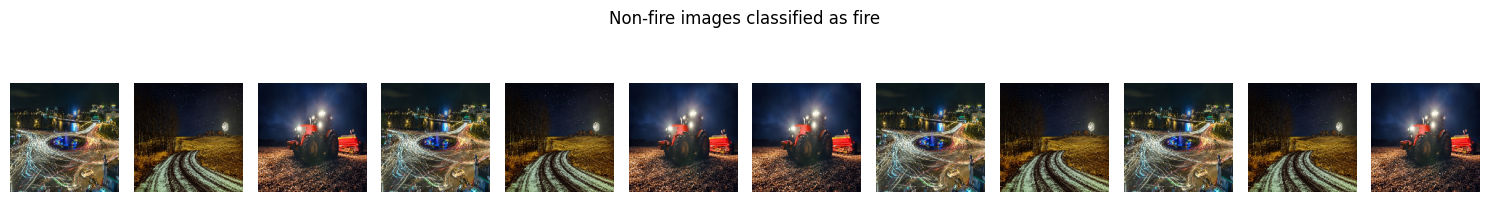

In [30]:
n = len(msd_nofire)
fig = plt.figure(figsize=(15, 4))
plt.suptitle('Non-fire images classified as fire')

for i, img_i in enumerate(msd_nofire):        
    ax = fig.add_subplot(2, n, i+1)
    ax.imshow(img_i)
    ax.axis('off')

plt.tight_layout()
plt.show()


Looking at this mis-classified set some of the picture actually seem to have fire. So, the problem is about the mis-labeling. Others don't have fire but have artificial red light or are picture with hue of dawn and dusk almost appearing as fire. 

Overall the model has done very good job separating those images with solid 97% accuracy in out of sample images. 

The Prediction


Model Performance Test:

Processing Your Images:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


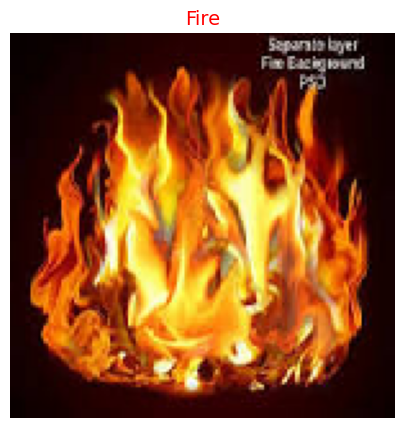

sample.jpeg: Fire
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


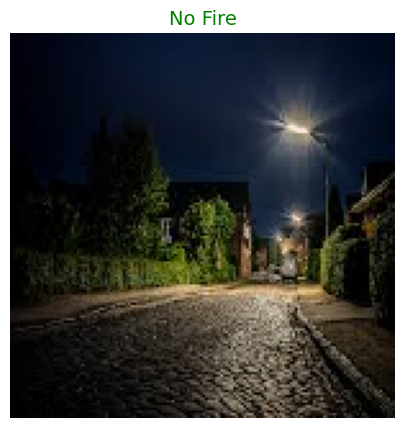

sample2.jpeg: No Fire
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


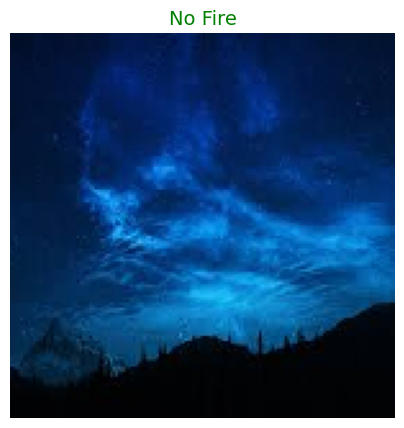

sample3.jpeg: No Fire
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


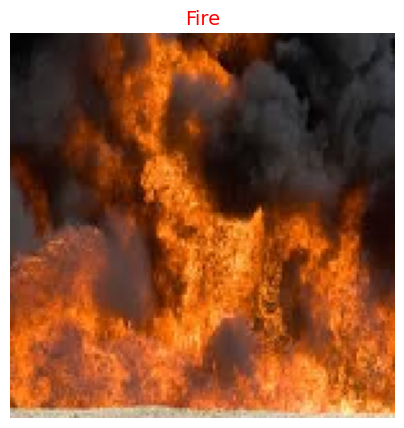

sample4.jpeg: Fire
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


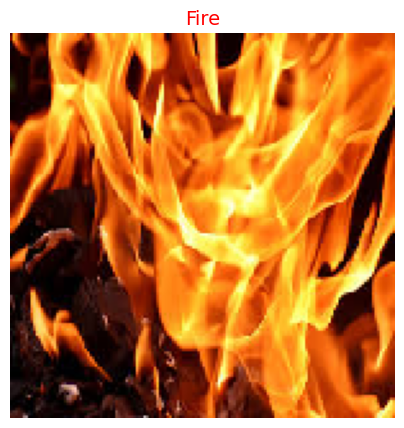

sample5.jpeg: Fire


In [61]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os

# Load the trained model
model = load_model("best_model.h5")

# Class labels (must match training label order)
class_labels = ['Fire', 'No Fire']

def predict_fire(img_path, threshold=0.5):
    """
    Predicts fire with confidence score
    
    Args:
        img_path: Path to image file
        threshold: Confidence threshold (0-1)
    
    Returns:
        Tuple of (predicted_label, confidence_score) or (None, None) if error
    """
    if not os.path.exists(img_path):
        return None, None
    
    try:
        # Load and preprocess image
        img = image.load_img(img_path, target_size=model.input_shape[1:3])
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        
        # Get prediction
        prediction = model.predict(img_array)
        fire_prob = float(prediction[0][0])
        
        # Determine label based on threshold
        label = class_labels[1] if fire_prob > threshold else class_labels[0]
        confidence = fire_prob if label == 'Fire' else 1 - fire_prob
        
        # Visualize
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        color = 'red' if label == 'Fire' else 'green'
        plt.title(f"{label}", color=color, fontsize=14)
        plt.axis('off')
        plt.show()
        
        return label, confidence
    
    except Exception as e:
        return None, None

def test_model_performance():
    """Test with known fire/no-fire images"""
    test_dir = "D:/Fire_Detection_Model/Images/test"
    test_images = {
        os.path.join(test_dir, "fire", "fire1.jpg"): "Fire",
        os.path.join(test_dir, "nofire", "nofire1.jpg"): "No Fire"
    }
    
    print("\nModel Performance Test:")
    for img_path, true_label in test_images.items():
        pred_label, confidence = predict_fire(img_path)
        if pred_label is not None:
            print(f"Image: {os.path.basename(img_path)}")
            print(f"True: {true_label} | Predicted: {pred_label}")
            print("-" * 50)

# Run diagnostics if test images exist
if os.path.exists("D:/Fire_Detection_Model/Images/test"):
    test_model_performance()

# Process sample images
sample_images = [
    "D:/Fire_Detection_Model/sample.jpeg",
    "D:/Fire_Detection_Model/sample2.jpeg", 
    "D:/Fire_Detection_Model/sample3.jpeg",
    "D:/Fire_Detection_Model/sample4.jpeg",
    "D:/Fire_Detection_Model/sample5.jpeg",
]

print("\nProcessing Your Images:")
for img in sample_images:
    label, conf = predict_fire(img)
    if label:
        print(f"{os.path.basename(img)}: {label}")

# Future direction 

- Although the accuracy is good VGG16 is large and slow to train. 

- Try other pre-trained networks: Xception (smaller size higher accuracy), MobileNet (much smaller in size with comparable accuracy). Look here: https://keras.io/api/applications/

- Have test, train and validation split: So far there is only test and validation set.